In [10]:
script_content = """
import os
import hashlib
from PIL import Image
import numpy as np
import shutil

# Folder paths
RAW_DATA_DIR = r'C:/Users/Admin/Downloads/archive/PCOS'
CLEANED_DATA_DIR = 'cleaned_PCOS'
IMAGE_SIZE = (240, 240)  # Resize target size (width x height)

# TEST MODE: Set to True to process only first N images for testing
TEST_MODE = False
TEST_LIMIT = 50

def remove_duplicates_and_resize():
    seen_hashes = set()

    for label in ['infected', 'noninfected']:
        source_dir = os.path.join(RAW_DATA_DIR, label)
        target_dir = os.path.join(CLEANED_DATA_DIR, label)
        os.makedirs(target_dir, exist_ok=True)

        filenames = os.listdir(source_dir)
        if TEST_MODE:
            filenames = filenames[:TEST_LIMIT]

        for idx, filename in enumerate(filenames, start=1):
            file_path = os.path.join(source_dir, filename)
            print(f"Processing {label}/{filename} ({idx}/{len(filenames)})")

            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in seen_hashes:
                print(f"Duplicate removed: {filename}")
                continue
            seen_hashes.add(file_hash)

            try:
                with Image.open(file_path) as img:
                    img = img.convert('RGB')
                    img_resized = img.resize(IMAGE_SIZE)
                    cleaned_filename = f"{file_hash}.jpg"
                    cleaned_path = os.path.join(target_dir, cleaned_filename)
                    img_resized.save(cleaned_path, 'JPEG')
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

    print("Cleaning & preprocessing complete.")

def main():
    if os.path.exists(CLEANED_DATA_DIR):
        shutil.rmtree(CLEANED_DATA_DIR)
    remove_duplicates_and_resize()

if __name__ == '__main__':
    main()
"""

with open("data_cleaning_preprocessing.py", "w", encoding="utf-8") as f:
    f.write(script_content)

print("Script created successfully with IMAGE_SIZE = (240, 240)")

Script created successfully with IMAGE_SIZE = (240, 240)


In [11]:
!python data_cleaning_preprocessing.py

Traceback (most recent call last):
  File "C:\Users\Admin\DIS Neural Networks\data_cleaning_preprocessing.py", line 59, in <module>
    main()
  File "C:\Users\Admin\DIS Neural Networks\data_cleaning_preprocessing.py", line 55, in main
    shutil.rmtree(CLEANED_DATA_DIR)
  File "C:\Users\Admin\miniconda3\envs\ann\Lib\shutil.py", line 787, in rmtree
    return _rmtree_unsafe(path, onerror)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\miniconda3\envs\ann\Lib\shutil.py", line 629, in _rmtree_unsafe
    _rmtree_unsafe(fullname, onerror)
  File "C:\Users\Admin\miniconda3\envs\ann\Lib\shutil.py", line 638, in _rmtree_unsafe
    onerror(os.rmdir, path, sys.exc_info())
  File "C:\Users\Admin\miniconda3\envs\ann\Lib\shutil.py", line 636, in _rmtree_unsafe
    os.rmdir(path)
OSError: [WinError 145] The directory is not empty: 'cleaned_PCOS\\infected'


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
import os
import random
import shutil

original_dataset_dir = 'cleaned_PCOS'
target_dir = 'cleaned_PCOS_split'
train_ratio = 0.7  # 70% training
val_ratio = 0.15   # 15% validation
test_ratio = 0.15  # 15% testing

classes = ['infected', 'noninfected']

for cls in classes:
    class_dir = os.path.join(original_dataset_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    train_target_dir = os.path.join(target_dir, 'train', cls)
    val_target_dir = os.path.join(target_dir, 'val', cls)
    test_target_dir = os.path.join(target_dir, 'test', cls)
    os.makedirs(train_target_dir, exist_ok=True)
    os.makedirs(val_target_dir, exist_ok=True)
    os.makedirs(test_target_dir, exist_ok=True)

    for fname in train_images:
        shutil.copy2(os.path.join(class_dir, fname), os.path.join(train_target_dir, fname))
    for fname in val_images:
        shutil.copy2(os.path.join(class_dir, fname), os.path.join(val_target_dir, fname))
    for fname in test_images:
        shutil.copy2(os.path.join(class_dir, fname), os.path.join(test_target_dir, fname))

print("Dataset successfully split into train, val, and test sets.")

Dataset successfully split into train, val, and test sets.


In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'cleaned_PCOS_split/train',
    image_size=(240, 240),
    batch_size=32,
    label_mode='binary'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    'cleaned_PCOS_split/val',
    image_size=(240, 240),
    batch_size=32,
    label_mode='binary'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    'cleaned_PCOS_split/test',
    image_size=(240, 240),
    batch_size=32,
    label_mode='binary'
)

class_names = train_dataset.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2796 files belonging to 2 classes.
Found 598 files belonging to 2 classes.
Found 602 files belonging to 2 classes.


In [4]:
infected_count = len(os.listdir('cleaned_PCOS_split/train/infected'))
noninfected_count = len(os.listdir('cleaned_PCOS_split/train/noninfected'))
total = infected_count + noninfected_count

weight_for_0 = (1 / noninfected_count) * (total / 2.0)
weight_for_1 = (1 / infected_count) * (total / 2.0)
penalty_factor = 3  
class_weight = {0: weight_for_0, 1: weight_for_1 * penalty_factor}

print("Class weights with penalty:", class_weight)

Class weights with penalty: {0: 2.461267605633803, 1: 1.8824057450628366}


In [5]:
inputs = Input(shape=(240, 240, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 238, 238, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 117, 117, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [7]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 948ms/step - accuracy: 0.7752 - loss: 1.0935 - val_accuracy: 0.7977 - val_loss: 0.4672 - learning_rate: 5.0000e-04
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8057 - loss: 0.9116 - val_accuracy: 0.7977 - val_loss: 0.3877 - learning_rate: 5.0000e-04
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8435 - loss: 0.7181 - val_accuracy: 0.8595 - val_loss: 0.3270 - learning_rate: 5.0000e-04
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 963ms/step - accuracy: 0.8724 - loss: 0.6567 - val_accuracy: 0.8645 - val_loss: 0.3260 - learning_rate: 5.0000e-04
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 908ms/step - accuracy: 0.8763 - loss: 0.6428 - val_accuracy: 0.8712 - val_loss: 0.3064 - learning_rate: 5.0000e-04
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 921ms/step - accuracy: 0.8632 - loss: 0.6558 - val_accuracy: 0.8729 - val_loss: 0.2942 - learning_rate: 5.0000e-04
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.

In [8]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.9130 - loss: 0.2027
Test Accuracy: 0.9286, Test Loss: 0.1727


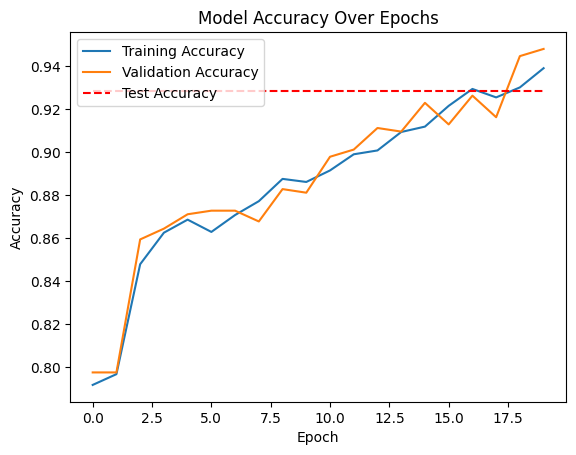

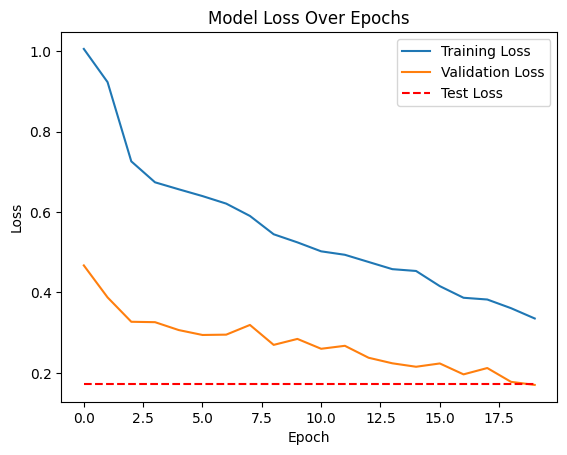

In [9]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.hlines(test_acc, 0, len(history.history['accuracy']) - 1, colors='red', linestyles='dashed', label='Test Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.hlines(test_loss, 0, len(history.history['loss']) - 1, colors='red', linestyles='dashed', label='Test Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


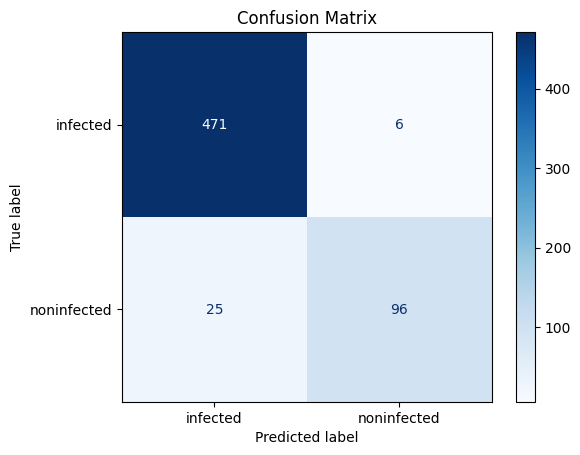

Confusion Matrix Values:
[[471   6]
 [ 25  96]]


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds.flatten() > 0.5).astype(int))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix Values:")
print(cm)

In [11]:
def get_gradcam_heatmap(model, image, class_index=None, last_conv_layer_name='conv2d_29'):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()


In [12]:
import tensorflow as tf
dummy_input = tf.random.normal((1, 240, 240, 3))
_ = model(dummy_input)

In [15]:
def save_gradcam_visualization(
    model,
    dataset,
    save_dir,
    num_images=5,
    last_conv_layer_name='conv2d_2',
    alpha=0.5,
    dpi=400
):
    os.makedirs(save_dir, exist_ok=True)
    count = 0

    for images, labels in dataset.unbatch().batch(32):
        for k in range(len(images)):
            img_uint8 = images[k].numpy().astype("uint8")
            label_scalar = int(labels[k].numpy().item())

            heatmap = get_gradcam_heatmap(
                model,
                images[k] / 255.0,
                last_conv_layer_name=last_conv_layer_name
            )

            heatmap_uint8 = (heatmap * 255).astype("uint8")
            heatmap_uint8 = np.array(
                Image.fromarray(heatmap_uint8).resize(
                    (img_uint8.shape[1], img_uint8.shape[0]),
                    resample=Image.BILINEAR
                )
            )
            heatmap_rgb = plt.cm.jet(heatmap_uint8 / 255.0)[..., :3]

            img_gray = tf.image.rgb_to_grayscale(img_uint8).numpy().squeeze()
            img_gray = np.stack([img_gray] * 3, axis=-1)

            blended = (1 - alpha) * img_gray / 255.0 + alpha * heatmap_rgb
            blended = np.clip(blended * 255, 0, 255).astype("uint8")

            fig, ax = plt.subplots(figsize=(8, 8))
            im = ax.imshow(blended.astype("uint8"), interpolation='nearest')
            ax.set_title(f'Grad-CAM\nTrue: {class_names[label_scalar]}', fontsize=14)
            ax.axis('off')

            cbar_img = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
            fig.colorbar(cbar_img, ax=ax, fraction=0.046, pad=0.04, label='Grad-CAM Intensity')

            save_path = os.path.join(
                save_dir,
                f'gradcam_{count}_label_{class_names[label_scalar]}.png'
            )
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
            plt.show()
            plt.close()

            print(f'Saved: {save_path}')
            count += 1
            if count >= num_images:
                return



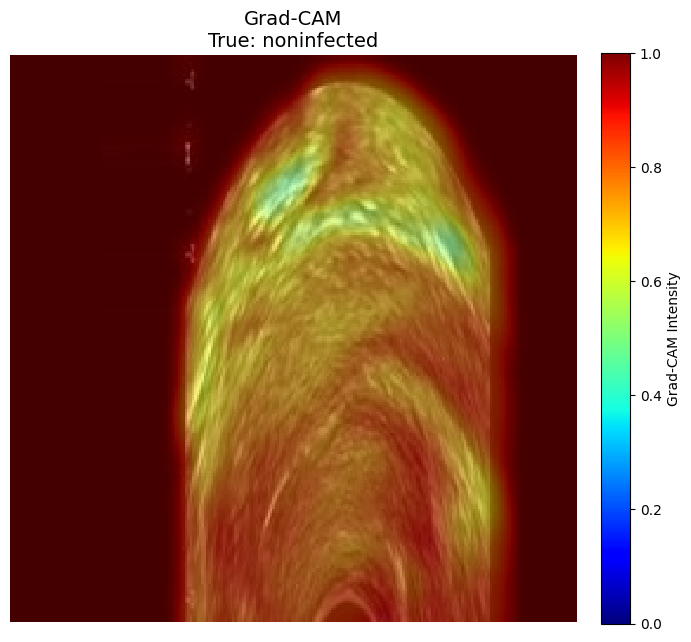

Saved: gradcam_outputs\gradcam_0_label_noninfected.png


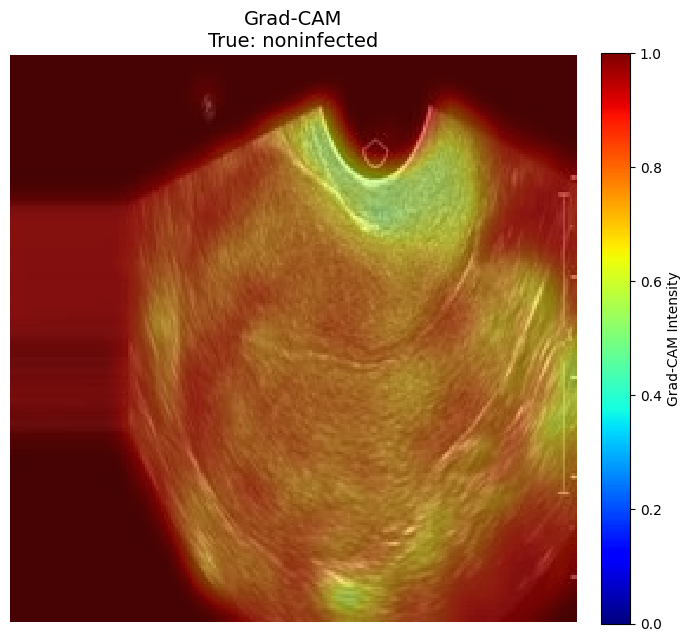

Saved: gradcam_outputs\gradcam_1_label_noninfected.png


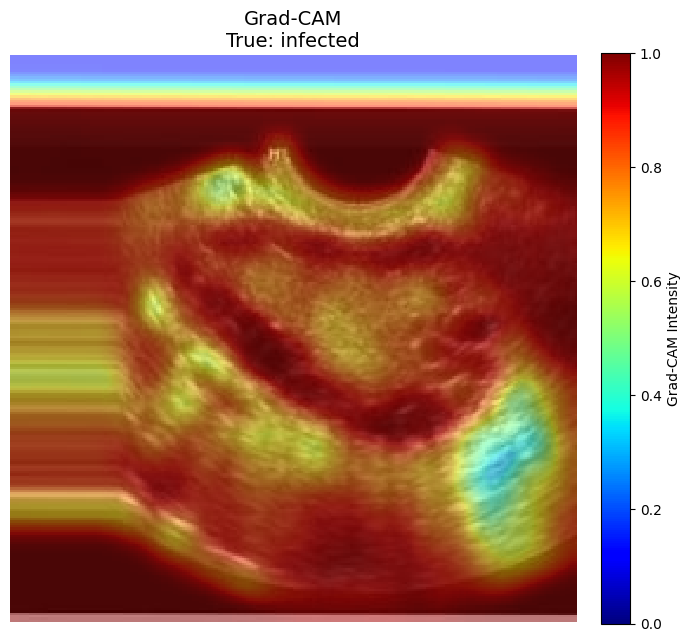

Saved: gradcam_outputs\gradcam_2_label_infected.png


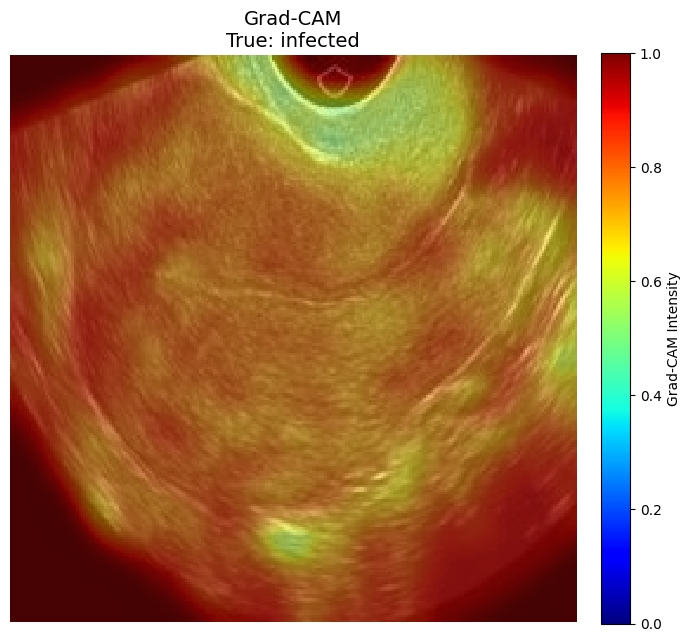

Saved: gradcam_outputs\gradcam_3_label_infected.png


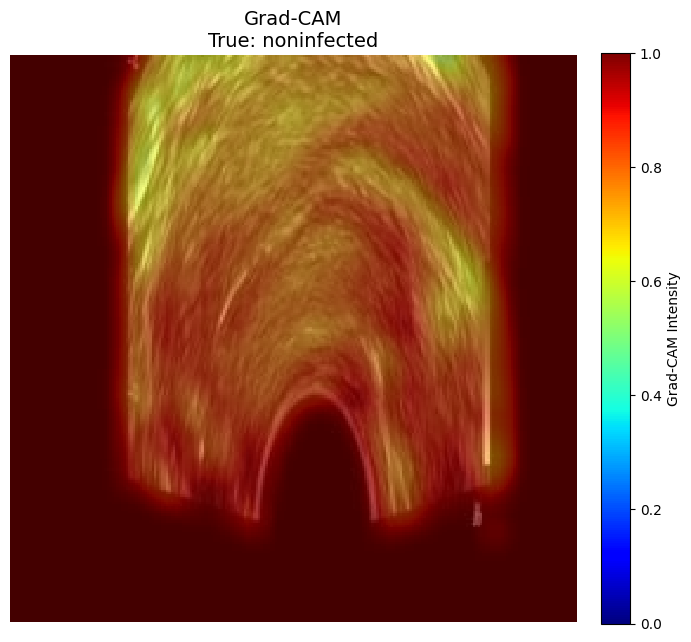

Saved: gradcam_outputs\gradcam_4_label_noninfected.png


In [17]:
from PIL import Image
save_gradcam_visualization(
    model,
    test_dataset, 
    save_dir='gradcam_outputs',
    num_images=5,
    last_conv_layer_name='conv2d_2'
)